In [1]:
import datetime
import io
import logging

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
### Mock parameters

if 0:
    # Countermeasures
    CMs = ["Stay home", "Respirators"]
    nCMs = len(CMs)
    # Countries
    Cs = ["CZ", "SK", "DE", "PL"]
    nCs = len(Cs)
    # Days
    Ds = [f"03-{i}" for i in range(10, 21)]
    nDs = len(Ds)

    # Probability of testing positive after transmission, from 0
    DelayProb = [0.1 for i in range(10)]

    ### Mock input data

    # [country, CM, day] Which CMs are active, and to what extent
    ActiveCMs = np.random.exponential(0.2, size=(nCs, nCMs, nDs)).astype(theano.config.floatX)

    # Mock growth rate [country, day]
    grate = np.random.lognormal(0.2, 0.2, size=(nCs, nDs))
    # cummulation of the daily rates * measurememt error
    Confirmed = np.cumprod(grate, axis=1) * np.random.lognormal(0.0, 0.3, size=(nCs, nDs)).astype(theano.config.floatX)
    #Confirmed[:,7] = np.nan

In [3]:
from epimodel import RegionDataset, read_csv, Level
rds = RegionDataset.load('../../data/regions.csv')
csse = read_csv('../../data/johns-hopkins.csv')
cms = read_csv('../../data/countermeasures-selected-binary.csv')
#cms.to_csv('../data/CMS_binary.csv')


[2020-04-10 18:07:09,011] INFO(epimodel.regions): Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']


In [4]:
#cms_full = import_simplified_countermeasures(rds, "../data/COVID 19 Containment measures data.csv")

In [5]:
### Real params and data

if 1:
    # Countermeasures
    CMs = ["Contact isolation", "Some businesses suspended","Many businesses suspended",
           "Schools and universities closed","Social distancing advised","Gatherings limited to 10 or less",
           "General curfew","General strict isolation"]
#,"Gatherings limited to 100", "Gatherings limited to 500",
#"Widespread mask usage (over 75%)", "Staying home advised",
    #CMs = ['Asymptomatic isolation - semi-targeted', 'International travel restriction', 'School closure', 'Healthcare specialisation', 'Resumption', 'Asymptomatic isolation - targeted', 'Assisting people to stay home', 'Diagnostic criteria tightened', 'Public cleaning', 'Asymptomatic isolation - blanket', 'Public interaction reduction', 'Domestic travel restriction', 'Symptomatic isolation - targeted', 'Nonessential business suspension', 'Mask wearing', 'Public education and incentives', 'Activity cancellation', 'Testing criteria', 'Symptomatic isolation - blanket']
    #CMS += ['Gatherings banned', 'Contact tracing', 'Testing']
    nCMs = len(CMs)
    # Countries
    Cs = ["DK", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "HU", "NO", "RO", "SE", "SI", "SK"]
    nCs = len(Cs)
    # Days
    FullDs = pd.date_range(start='2020-02-10', end='2020-04-01', tz='utc')
    #[datetime.date(2020,2,i) for i in range(20, 30)] + [datetime.date(2020,3,i) for i in range(1, 29)]
    # HACK: Assume fixed 7 days to CM effect
    CM_Ds = FullDs[:-7]
    JH_Ds = FullDs[7:]
    JHName = "Confirmed"

    nDs = len(CM_Ds)

    # Probability of testing positive after transmission, from 0
    #DelayProb = [0.00, 0.01, 0.02, 0.05, 0.09, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03, 0.01, 0.01]

    # [country, CM, day] Which CMs are active, and to what extent
    sd = cms.loc[Cs, CMs]
    for cm in CMs:
        d = cms[cm]
        print(f"{cm[:50]:50} {d.min().min():.3f} .. {d.mean().mean():.3f} .. {d.max().max():.3f}")
    ActiveCMs = np.stack([sd.loc[c].loc[CM_Ds].T for c in Cs])
    print(ActiveCMs.shape, (nCs, nCMs, nDs))

    #ActiveCMs = np.stack([sd.loc[Cs, [(cm, d) for d in CM_Ds]].values for cm in CMs], axis=1)
    assert ActiveCMs.shape == (nCs, nCMs, nDs)
    ActiveCMs = ActiveCMs.astype(theano.config.floatX)

    # [country, day]
    Confirmed = csse[JHName].loc[(tuple(Cs), JH_Ds)].unstack(1).values
    print(Confirmed.shape)
    assert Confirmed.shape == (nCs, nDs)
    Confirmed[Confirmed < 5.0] = np.nan
    Confirmed = np.ma.masked_invalid(Confirmed.astype(theano.config.floatX))


Contact isolation                                  0.000 .. 0.038 .. 1.000
Some businesses suspended                          0.000 .. 0.083 .. 1.000
Many businesses suspended                          0.000 .. 0.104 .. 1.000
Schools and universities closed                    0.000 .. 0.146 .. 1.000
Social distancing advised                          0.000 .. 0.018 .. 1.000
Gatherings limited to 10 or less                   0.000 .. 0.027 .. 1.000
General curfew                                     0.000 .. 0.020 .. 1.000
General strict isolation                           0.000 .. 0.034 .. 1.000
(17, 8, 45) (17, 8, 45)
(17, 45)


In [6]:
with pm.Model() as model:
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    BaseGrowthRate = pm.Lognormal("BaseGrowthRate", np.log(1.2), 2.0)
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Lognormal("InitialSize", 0.0, 10, shape=(nCs,))
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Lognormal("CountryGrowthRate", pm.math.log(BaseGrowthRate), 0.3, shape=(nCs,))
    # [CM] How much countermeasures reduce growth rate
    # TODO: Estimate variance, or use another dist.
    CMReductionGamma = pm.Gamma("CMReductionGamma", 0.5, 1.0, shape=(nCMs,))
    CMReduction = pm.Deterministic("CMReduction", T.exp((-1.0) * CMReductionGamma))
    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReduction, (1, nCMs, 1)) ** ActiveCMs
    # [country, day] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.prod(ActiveCMReduction, axis=1))
    # [country, day] The ideal predicted daily growth
    PreictedGrowth = pm.Deterministic("PreictedGrowth", T.reshape(CountryGrowthRate, (nCs, 1)) * GrowthReduction)
    # [country, day] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Lognormal("DailyGrowth", pm.math.log(PreictedGrowth), 0.1, shape=(nCs, nDs))

    # Below I assume plain exponentia growth of confirmed rather than e.g. depending on the remaining
    # susceptible opulation etc. (Would be needed in later stages, though)

    # [country, day] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) * DailyGrowth.cumprod(axis=1))
    # [country, day] Cummulative tested positives
    Observed = pm.Lognormal("Observed", pm.math.log(Size), 0.4, shape=(nCs, nDs), observed=Confirmed)


In [7]:
print(model.check_test_point())
with model:
    trace = pm.sample(2000, chains=2, cores=2, init='adapt_diag')

[2020-04-10 18:07:19,469] INFO(pymc3): Auto-assigning NUTS sampler...
[2020-04-10 18:07:19,470] INFO(pymc3): Initializing NUTS using adapt_diag...


BaseGrowthRate_log__           -1.61
InitialSize_log__             -54.77
CountryGrowthRate_log__         4.85
CMReductionGamma_log__        -11.35
DailyGrowth_log__            1058.49
Observed_missing                0.00
Observed                  -273813.26
Name: Log-probability of test_point, dtype: float64


[2020-04-10 18:07:22,591] INFO(pymc3): Multiprocess sampling (2 chains in 2 jobs)
[2020-04-10 18:07:22,592] INFO(pymc3): NUTS: [Observed_missing, DailyGrowth, CMReductionGamma, CountryGrowthRate, InitialSize, BaseGrowthRate]
Sampling 2 chains, 247 divergences: 100%|██████████| 5000/5000 [04:14<00:00, 19.65draws/s]
[2020-04-10 18:11:44,861] ERROR(pymc3): There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-04-10 18:11:44,862] ERROR(pymc3): There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-04-10 18:11:44,863] WARNING(pymc3): The acceptance probability does not match the target. It is 0.8971751091669454, but should be close to 0.8. Try to increase the number of tuning steps.
[2020-04-10 18:11:44,871] ERROR(pymc3): The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7072842ad0>,
      dtype=object)

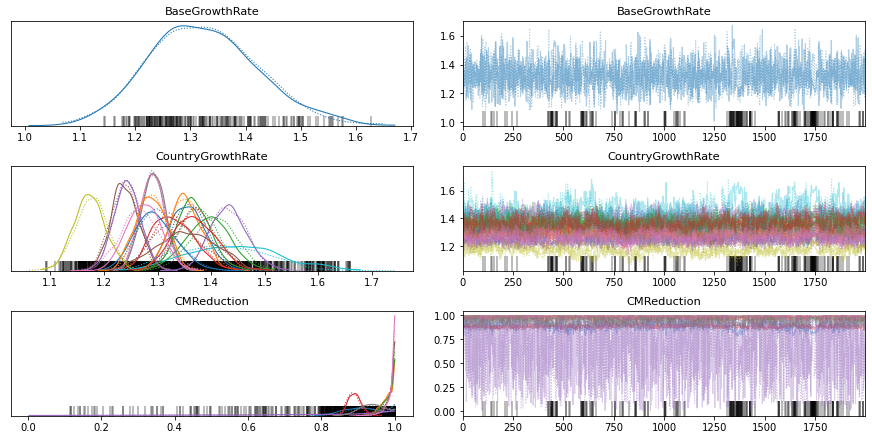

In [8]:
pm.traceplot(trace, var_names=["BaseGrowthRate", "CountryGrowthRate", "CMReduction"])

0: Contact isolation, 1: Some businesses suspended, 2: Many businesses suspended, 3: Schools and universities closed, 4: Social distancing advised, 5: Gatherings limited to 10 or less, 6: General curfew, 7: General strict isolation


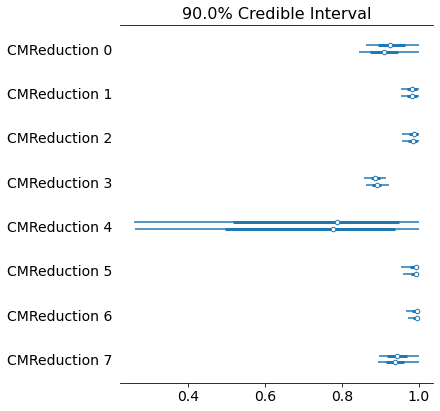

In [9]:
pm.forestplot(trace, varnames=['CMReduction'], credible_interval=0.9)
print(', '.join(f"{i}: {c}" for i, c in enumerate(CMs)))

In [ ]:
import plotly
import chart_studio.plotly as py
from plotly import graph_objects as go
import plotly.express as px

fig = go.Figure()
x = list(JH_Ds)
x_rev = x[::-1]
print(trace['DailyGrowth'].shape)
for i, c in enumerate(Cs):
    d = trace['DailyGrowth'][:,i,:]
    y = list(d.mean(axis=0))
    ylo = list(np.quantile(d, 0.05, axis=0))
    yhi = list(np.quantile(d, 0.95, axis=0))
    color = px.colors.qualitative.Light24[i]
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        name=c, legendgroup=c, line_color=color
    ))    
    fig.add_trace(go.Scatter(
        x=x+x[::-1],
        y=ylo+yhi[::-1],
        fill='toself',
        fillcolor=color,
        opacity=0.15,
        line_color='rgba(255,255,255,0)',
        showlegend=False,
        name=c, legendgroup=c,
    ))    
fig.show()
plotly.io.write_html(fig, 'daily_growth_rates.html', include_plotlyjs='cdn')